# Computationally-defined markers of uncertainty aversion predict trajectories of perceived threat and anxiety during a global pandemic
### Wise\*, Zbozinek\*, Charpentier, Michelini, Hagan & Mobbs (2021)

## Behavioural analysis

### Imports

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import matplotlib as mpl
import statsmodels.formula.api as smf
from sklearn.preprocessing import scale
import textwrap
from sklearn.preprocessing import minmax_scale
from tqdm.notebook import tqdm
from scipy.stats import pearsonr
mpl.style.use('toby')
colours = ['#' + i for i in '267fd3-d3265a-fc9403-44af69'.split('-')] + ['#197278']

## Get data

### Model fitting data

First, we get hold of all the model fit results, one for each candidate model, and put them into a pandas `DataFrame`

In [12]:
result_dir = '../data/gamble_fit_results/'

result_df = []

for i in tqdm(os.listdir(result_dir)):
    if 'csv' in i and not 'RECOVERY' in i:
        df = pd.read_csv(os.path.join(result_dir, i))
        df = df[~df['parameter'].str.contains('estimated')]
        if 'model_id' in df:
            df = df.rename(columns={'model_id': 'decision_model_id'})
            df['learning_model_id'] = 0
        result_df.append(df)
    
result_df = pd.concat(result_df)

### Raw gambling data

We then get the raw behavioural data for use in calculating model-free measures.

In [13]:
gamble_data = pd.read_csv('../data/gamble_data_anon.csv')
gamble_data = gamble_data.sort_values(['subjectID', 'trial_number'])

In [14]:
gamble_data.head()

,block,date,gamble,gamble_chosen,gamble_location,internal_node_id,key_press,number1,number2,number3,...,basepic,amb_1,amb_2,amb_3,gamble_1,gamble_2,gamble_3,exclude_1,exclude_2,exclude_3
179,1.0,3/13/2020,False,1,none,0.0-2.0-0.0,80,0.0,5.0,-2.0,...,base2.png,0,0,0,0,1,1,0,0,0
658,1.0,3/13/2020,False,1,none,0.0-2.0-1.0,80,0.0,5.0,-6.0,...,base2.png,0,0,0,0,1,1,0,0,0
1137,1.0,3/13/2020,False,1,none,0.0-2.0-2.0,80,0.0,6.0,-3.0,...,base2.png,0,0,0,0,1,1,0,0,0
1616,1.0,3/13/2020,False,1,none,0.0-2.0-3.0,80,0.0,6.0,-2.0,...,base2.png,0,0,0,0,1,1,0,0,0
2095,1.0,3/13/2020,True,1,left,0.0-2.0-4.0,81,7.0,-4.0,0.0,...,base1.png,0,0,0,1,1,0,0,0,0


### Calculate model-free behavioural measures

Here we calculate the behavioural measures of interest. These are all calculated such that higher = more averse to make things more easily interpretable.

* Proportion of gambles chosen in conditions 1 - 6 (~overall risk aversion)
* Proportion of risky choice in condition 1 vs 4 (~loss aversion)
* 1 - Proportion of risky choice in condition 4 only (~risk aversion)
* 1 - Proportion of ambiguous choice in condition 7 (~ambiguity aversion for sure gains)
* 1 - Proportion of risky choice in condition 8 (~ambiguity aversion for sure losses)
* 1 - Proportion of risky choice in condition 5 (~ambiguity aversion for risky gains)
* 1 - Proportion of risky choice in condition 2 (~ambiguity aversion for risky losses)
* Proportion of risky choice in condition 4 vs 6 (~general ambiguity aversion)

In [15]:
mf_gamble_measures = {'subjectID': gamble_data['subjectID'].unique(),
                      'total_gamble_chosen' : (1- gamble_data[gamble_data['condition'] < 7].groupby('subjectID').mean()['gamble_chosen'].values),
                      'cond_1vs4': gamble_data[gamble_data['condition'] == 4].groupby('subjectID').mean()['gamble_chosen'].values - gamble_data[gamble_data['condition'] == 1].groupby('subjectID').mean()['gamble_chosen'].values,
                      'cond_4': (1- gamble_data[gamble_data['condition'] == 4].groupby('subjectID').mean()['gamble_chosen'].values),
                      'cond_7': (1- gamble_data[gamble_data['condition'] == 7].groupby('subjectID').mean()['gamble_chosen'].values),
                      'cond_8': (1- gamble_data[gamble_data['condition'] == 8].groupby('subjectID').mean()['gamble_chosen'].values),
                      'cond_2': (1- gamble_data[gamble_data['condition'] == 2].groupby('subjectID').mean()['gamble_chosen'].values),
                      'cond_5': (1- gamble_data[gamble_data['condition'] == 5].groupby('subjectID').mean()['gamble_chosen'].values),
                      'cond_4vs6': gamble_data[gamble_data['condition'] == 4].groupby('subjectID').mean()['gamble_chosen'].values - gamble_data[gamble_data['condition'] == 6].groupby('subjectID').mean()['gamble_chosen'].values}

mf_gamble_measures = pd.DataFrame(mf_gamble_measures)
mf_gamble_measures.columns = ['MFGAMBLE_' + c if not 'subject' in c else c for c in mf_gamble_measures.columns ]

### Plot distributions of risk, loss and ambiguity aversion

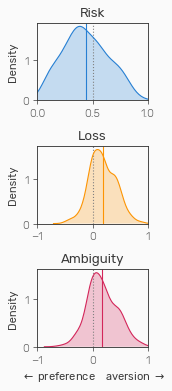

In [16]:
fix, ax = plt.subplots(3, 1, figsize=(2.3, 5), dpi=80)

ax[0].set_ylabel('Density')
ax[1].set_ylabel('Density')
ax[2].set_ylabel('Density')

# No bias lines
ax[0].axvline(0.5, linestyle=':', linewidth=1, color='gray')
ax[1].axvline(0, linestyle=':', linewidth=1, color='gray')
ax[2].axvline(0, linestyle=':', linewidth=1, color='gray')

# Means
ax[0].axvline(mf_gamble_measures['MFGAMBLE_total_gamble_chosen'].mean(), linestyle='-', linewidth=1, color=colours[0])
ax[1].axvline(mf_gamble_measures['MFGAMBLE_cond_1vs4'].mean(), linestyle='-', linewidth=1, color=colours[2])
ax[2].axvline(mf_gamble_measures['MFGAMBLE_cond_4vs6'].mean(), linestyle='-', linewidth=1, color=colours[1])


sns.kdeplot(mf_gamble_measures['MFGAMBLE_total_gamble_chosen'], linewidth=1, shade=True, color=colours[0], ax=ax[0], legend=False)
ax[0].set_title('Risk')
# ax[0].set_xlabel(r'$\leftarrow$ preference    aversion $\rightarrow$')
ax[0].set_xlim(0, 1)
sns.kdeplot(mf_gamble_measures['MFGAMBLE_cond_1vs4'], linewidth=1, shade=True, color=colours[2], ax=ax[1], legend=False)
ax[1].set_title('Loss')
# ax[1].set_xlabel(r'$\leftarrow$ preference    aversion $\rightarrow$')
ax[1].set_xlim(-1, 1)
sns.kdeplot(mf_gamble_measures['MFGAMBLE_cond_4vs6'], linewidth=1, shade=True, color=colours[1], ax=ax[2], legend=False)
ax[2].set_title('Ambiguity')
ax[2].set_xlabel(r'$\leftarrow$ preference    aversion $\rightarrow$')
ax[2].set_xlim(-1, 1)

plt.tight_layout()

# plt.savefig('../figures/choice_distributions.svg')

### Test for differences from zero

We check whether these values are different from zero (implying no preference/aversion) at the group level using a one-sample t-test.

In [17]:
from scipy.stats import ttest_1samp

t, p = ttest_1samp(mf_gamble_measures['MFGAMBLE_total_gamble_chosen'], 0.5)
print("Mean risk preference = {0}, t({1})={2}, p={3}".format(mf_gamble_measures['MFGAMBLE_total_gamble_chosen'].mean(), 
                                                             len(mf_gamble_measures['MFGAMBLE_total_gamble_chosen']) - 1, np.round(t, 2), np.round(p, 20)))

t, p = ttest_1samp(mf_gamble_measures['MFGAMBLE_cond_1vs4'], 0)
print("Mean loss preference = {0}, t({1})={2}, p={3}".format(mf_gamble_measures['MFGAMBLE_cond_1vs4'].mean(), 
                                                             len(mf_gamble_measures['MFGAMBLE_cond_1vs4']) - 1, np.round(t, 2), np.round(p, 20)))

t, p = ttest_1samp((-mf_gamble_measures['MFGAMBLE_cond_4vs6']), 0)
print("Mean ambiguity preference = {0}, t({1})={2}, p={3}".format(mf_gamble_measures['MFGAMBLE_cond_4vs6'].mean(), 
                                                             len(mf_gamble_measures['MFGAMBLE_cond_4vs6']) - 1, np.round(t, 2), np.round(p, 20)))

Mean risk preference = 0.4373566053740872, t(478)=-6.77, p=3.681847426e-11
Mean loss preference = 0.1806097202548521, t(478)=16.69, p=0.0
Mean ambiguity preference = 0.17622867188848948, t(478)=-14.4, p=0.0


## Model fit

Next we assess the model fit of the different computational models using WAIC scores.

### Decision models

* Model 1: traditional prospect theory model; $\alpha_{rg}$ = $\alpha_{sg}$ = $\alpha_{rl}$ = $\alpha_{sg}$ = 1 (no ambiguity preference or aversion)
* Model 2: single ambiguity parameter; $\alpha_{rg}$ = $\alpha_{sg}$ = $\alpha_{rl}$ = $\alpha_{sg}$ = $\alpha$
* Model 3: separate ambiguity parameters for gains and losses; $\alpha_{rg}$ = $\alpha_{sg}$ = $\alpha_{g}$ and $\alpha_{rl}$ = $\alpha_{sg}$ = $\alpha_{l}$
* Model 4: separate ambiguity parameters for no-loss contexts (i.e. only values ≥$0 are present in the trial) and loss context (i.e. at least one loss is present in the trial)
* Model 5: separate ambiguity parameters for sure/risky gains/losses

### Learning models

#### Rescorla-Wagner models
* Model 1: RW learning - estimating learning rate
* Model 2: RW learning - estimating learning rate and single initial value for reward/loss
* Model 3: RW learning - estimating learning rate and different initial value for reward/loss
* Model 4: RW learning - estimating different learning rates for reward/loss
* Model 5: RW learning - estimating different learning rates for reward/loss and single initial value for reward/loss
* Model 6: RW learning - estimating different learning rates for reward/loss and different initial value for reward/loss

#### Bayesian models (Bayesian mean tracker)
Model has different Kalman gain for rewards and losses because this depends on the variance of the value being estimated, and we're estimating reward/loss separately
* Model 7: BMT learning - estimating theta, different learning rates for reward/loss
* Model 8: BMT learning - estimating theta, different learning rates for reward/loss and single initial value for reward/loss
* Model 9: BMT learning - estimating theta, different learning rates for reward/loss and different initial value for reward/loss

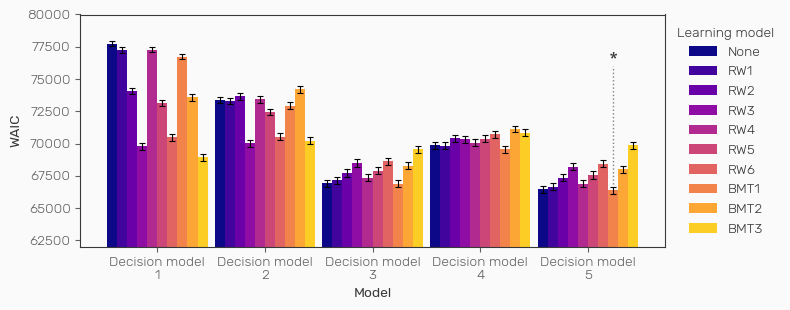

In [18]:
cmap = mpl.cm.get_cmap('plasma')
hues = cmap(np.linspace(0, 0.9, 10))
hues = [mpl.colors.to_hex(i) for i in hues]

plt.figure(figsize=(8, 3.2), dpi=100)
colours = ['#' + i for i in '267fd3-d3265a-ffbc42-44af69'.split('-')] + ['#197278']

grouped_waics = result_df.groupby(['decision_model_id', 'learning_model_id'])[['WAIC', 'WAIC_SE']].mean().reset_index()
model_labels = grouped_waics[['decision_model_id', 'learning_model_id']]
model_waics = grouped_waics['WAIC']
model_ses = grouped_waics['WAIC_SE']

n_models = len(model_waics)

x_values = np.arange(n_models) + np.arange(5).repeat(10) * 0.7

learning_models = ['None', 'RW1', 'RW2', 'RW3', 'RW4', 'RW5', 'RW6', 'BMT1', 'BMT2', 'BMT3']

best_waic_idx = np.argmin(model_waics)

for i in range(n_models):
    if i < 10:
        plt.bar(x_values[i], model_waics[i], yerr=model_ses[i],
                color=(hues * 5)[i], width=1, label=learning_models[i], error_kw=dict(lw=0.8, capsize=2, capthick=0.8))
    else:
        plt.bar(x_values[i], model_waics[i], yerr=model_ses[i],
                color=(hues * 5)[i], width=1, error_kw=dict(lw=0.8, capsize=2, capthick=0.8))

plt.xticks(np.arange(5) * 10 + np.arange(5) * 0.7 + 4.5, ['Decision model\n' + str(i) for i in range(1, 6)])
plt.ylim(62000, 80000)
plt.text(x_values[best_waic_idx] - 0.4, 76000, '*', size=15)
plt.plot([x_values[best_waic_idx], x_values[best_waic_idx]], [np.min(model_waics) + 500, 76000], color='gray', linestyle = ':')
plt.ylabel('WAIC')
plt.xlabel('Model')
plt.legend(bbox_to_anchor=(1, 1), title='Learning model', frameon=False)

plt.tight_layout()

# plt.savefig('../figures/GAMBLING_model_fit.svg')

## Combine data for winning model with behavioural data

Parameter values are reverse-coded if necessary to ensure that higher = more averse. Here we also add generated values from the model to allow us to look at dynamic learning rates from the BMT model family

In [19]:
winning_model_df = result_df[result_df['WAIC'] == result_df['WAIC'].min()].pivot(index='subjectID', columns='parameter', values='mean').reset_index()
winning_model_df_sd = result_df[result_df['WAIC'] == result_df['WAIC'].min()].pivot(index='subjectID', columns='parameter', values='sd').reset_index()
winning_model_df_sd.columns = [c + '_sd' if not 'subject' in c else c for c in winning_model_df_sd.columns]

# Reverse parameter values
winning_model_df['alpha_rg'] = winning_model_df['alpha_rg'].max() - winning_model_df['alpha_rg']
winning_model_df['alpha_sg'] = winning_model_df['alpha_sg'].max() - winning_model_df['alpha_sg']
winning_model_df['rho'] = winning_model_df['rho'].max() - winning_model_df['rho']

# Generated values (learning rates)
generated_values_df = result_df[result_df['WAIC'] == result_df['WAIC'].min()][['subjectID'] + [c for c in result_df if 'estimated' in c]].drop_duplicates()
generated_values_df['estimated_LR_diff'] = generated_values_df['estimated_amb_gain_LR'] - generated_values_df['estimated_amb_loss_LR']
generated_values_df['estimated_LR_diff_sd'] = (generated_values_df['estimated_amb_gain_LR_sd'] + generated_values_df['estimated_amb_loss_LR_sd']) / 2

# Put everything together
winning_model_df = pd.merge(winning_model_df, winning_model_df_sd, on='subjectID')
winning_model_df = pd.merge(winning_model_df, generated_values_df, on='subjectID')
merged_df = pd.merge(winning_model_df, mf_gamble_measures, on='subjectID')

## Plot distributions of parameter values

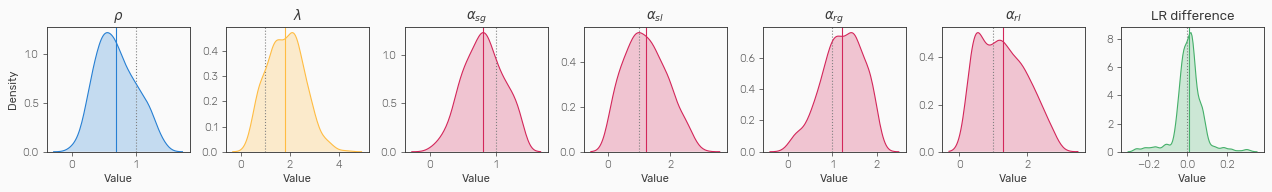

In [20]:
fix, ax = plt.subplots(1, 7, figsize=(16, 2.5), dpi=80)

ax[0].set_ylabel('Density')

# No bias lines
for i in range(6):
    ax[i].axvline(1, linestyle=':', linewidth=1, color='gray')
ax[6].axvline(0, linestyle=':', linewidth=1, color='gray')

param_names = [r'$\rho$', r'$\lambda$'] + [r'$\{0}$'.format(p.replace('_', '_{') + '}') for p in ['alpha_sg', 'alpha_sl', 'alpha_rg', 'alpha_rl']] + ['LR difference']
param_colours = [colours[0], colours[2]] + [colours[1]] * 4 + [colours[3]]

for n, i in enumerate(['rho', 'lambda', 'alpha_sg', 'alpha_sl', 'alpha_rg', 'alpha_rl', 'estimated_LR_diff']):
    
    # Means
    ax[n].axvline(merged_df[i].mean(), linestyle='-', linewidth=1, color=param_colours[n])

    sns.kdeplot(merged_df[i], linewidth=1, shade=True, color=param_colours[n], ax=ax[n], legend=False)
    
    ax[n].set_title(param_names[n])
    ax[n].set_xlabel('Value')

plt.tight_layout()

# plt.savefig('../figures/parameter_values.svg')

## Plot correlations between parameters and model-free measures

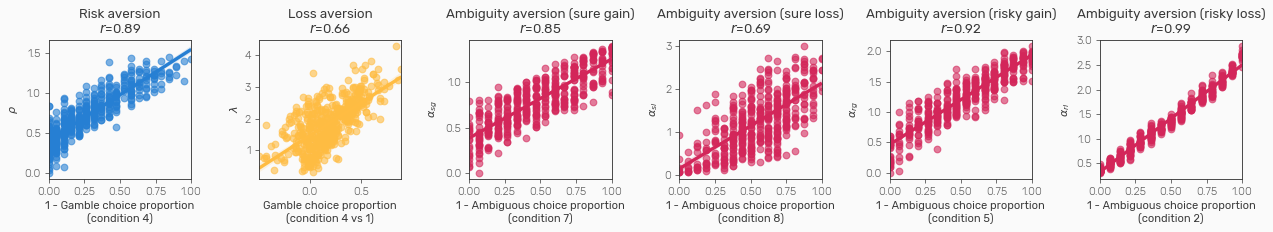

In [21]:
f, ax = plt.subplots(1, 6, figsize=(16, 3))

# Risk aversion
sns.regplot('MFGAMBLE_cond_4', 'rho', data=merged_df, ax=ax[0], color=colours[0], line_kws={'lw':3}, scatter_kws={'alpha': 0.6})
ax[0].set_xlabel('1 - Gamble choice proportion\n(condition 4)')
ax[0].set_ylabel(r'$\rho$')
ax[0].set_title('Risk aversion\n' + r'$r$={0}'.format(np.round(pearsonr(merged_df['rho'], merged_df['MFGAMBLE_cond_4'])[0], 2)))

# Loss aversion
sns.regplot('MFGAMBLE_cond_1vs4', 'lambda', data=merged_df, ax=ax[1], color=colours[2], line_kws={'lw':3}, scatter_kws={'alpha': 0.6})
ax[1].set_xlabel('Gamble choice proportion\n(condition 4 vs 1)')
ax[1].set_ylabel(r'$\lambda$')
ax[1].set_title('Loss aversion\n' + r'$r$={0}'.format(np.round(pearsonr(merged_df['lambda'], merged_df['MFGAMBLE_cond_1vs4'])[0], 2)))

for n, p in enumerate(['alpha_sg', 'alpha_sl', 'alpha_rg', 'alpha_rl']):
    if '_sg' in p:
        sns.regplot('MFGAMBLE_cond_7', p, data=merged_df, ax=ax[n+2], color=colours[1], line_kws={'lw':3}, scatter_kws={'alpha': 0.6})
        ax[n+2].set_xlabel('1 - Ambiguous choice proportion\n(condition 7)')
        ax[n+2].set_title('Ambiguity aversion (sure gain)\n' + r'$r$={0}'.format(np.round(pearsonr(merged_df[p], merged_df['MFGAMBLE_cond_7'])[0], 2), p.replace('_', '_{') + '}'))
    elif '_sl' in p:
        sns.regplot('MFGAMBLE_cond_8', p, data=merged_df, ax=ax[n+2], color=colours[1], line_kws={'lw':3}, scatter_kws={'alpha': 0.6})
        ax[n+2].set_xlabel('1 - Ambiguous choice proportion\n(condition 8)')
        ax[n+2].set_title('Ambiguity aversion (sure loss)\n' + r'$r$={0}'.format(np.round(pearsonr(merged_df[p], merged_df['MFGAMBLE_cond_8'])[0], 2), p.replace('_', '_{') + '}'))
    elif 'rg' in p:
        sns.regplot('MFGAMBLE_cond_5', p, data=merged_df, ax=ax[n+2], color=colours[1], line_kws={'lw':3}, scatter_kws={'alpha': 0.6})
        ax[n+2].set_xlabel('1 - Ambiguous choice proportion\n(condition 5)')
        ax[n+2].set_title('Ambiguity aversion (risky gain)\n' + r'$r$={0}'.format(np.round(pearsonr(merged_df[p], merged_df['MFGAMBLE_cond_5'])[0], 2), p.replace('_', '_{') + '}'))
    elif 'rl' in p:
        sns.regplot('MFGAMBLE_cond_2', p, data=merged_df, ax=ax[n+2], color=colours[1], line_kws={'lw':3}, scatter_kws={'alpha': 0.6})
        ax[n+2].set_xlabel('1 - Ambiguous choice proportion\n(condition 2)')
        ax[n+2].set_title('Ambiguity aversion (risky loss)\n' + r'$r$={0}'.format(np.round(pearsonr(merged_df[p], merged_df['MFGAMBLE_cond_2'])[0], 2), p.replace('_', '_{') + '}'))
    ax[n+2].set_ylabel(r'$\{0}$'.format(p.replace('_', '_{') + '}'))
    

plt.tight_layout()
# plt.savefig('../figures/parameter_correlations.svg')

## Save modelling data to csv

In [22]:
winning_model_df.to_csv('../data/model_measures.csv', index=False)
mf_gamble_measures.to_csv('../data/mf_gamble_measures.csv', index=False)

## Get demographic information

In [72]:
demographic_data = pd.read_csv('../data/demographics_anon.csv')

### Age

In [40]:
print('Mean age (SD) = {0} ({1})'.format(demographic_data['age'].mean(), demographic_data['age'].std()))

Mean age (SD) = 33.67763157894737 (11.846603059467427)


### Get factor data

In [87]:
T1_EFA_data = pd.read_csv('../data/T1_EFA_data_anon.csv')
T1_factor_data = pd.read_csv('../data/T1_factor_scores_anon.csv')
longitudinal_data = pd.read_csv('../data/longitudinal_data_gambling_anon.csv')

#### T1 task sample

In [73]:
demographic_data[demographic_data['subjectID'].isin(T1_factor_data['id'])]['Sex'].value_counts()

Female          267
Male            171
Not reported     14
Name: Sex, dtype: int64

In [74]:
demographic_data[demographic_data['subjectID'].isin(T1_factor_data['id'])]['age'].describe()

count    445.000000
mean      33.561798
std       11.878851
min       18.000000
25%       25.000000
50%       31.000000
75%       40.000000
max       77.000000
Name: age, dtype: float64

In [75]:
demographic_data[demographic_data['subjectID'].isin(T1_factor_data['id'])]['age'].isnull().sum()

7

#### T1 EFA sample

In [76]:
demographic_data[demographic_data['subjectID'].isin(T1_EFA_data['id'])]['Sex'].value_counts()

Female          580
Male            449
Not reported     67
Name: Sex, dtype: int64

In [78]:
len(T1_EFA_data) - demographic_data[demographic_data['subjectID'].isin(T1_EFA_data['id'])]['Sex'].value_counts().sum() 

5

In [80]:
demographic_data[demographic_data['subjectID'].isin(T1_EFA_data['id'])]['age'].describe()

count    1064.000000
mean       32.845865
std        12.581128
min        18.000000
25%        23.000000
50%        29.000000
75%        38.250000
max        80.000000
Name: age, dtype: float64

In [81]:
demographic_data[demographic_data['subjectID'].isin(T1_EFA_data['id'])]['age'].isnull().sum()

32

#### Longitudinal sample

In [88]:
demographic_data[demographic_data['subjectID'].isin(longitudinal_data['id'])]['Sex'].value_counts()

Female          148
Male            103
Not reported      8
Name: Sex, dtype: int64

In [89]:
demographic_data[demographic_data['subjectID'].isin(longitudinal_data['id'])]['age'].describe()

count    255.000000
mean      34.447059
std       12.294457
min       18.000000
25%       25.000000
50%       31.000000
75%       40.000000
max       77.000000
Name: age, dtype: float64

In [91]:
demographic_data[demographic_data['subjectID'].isin(longitudinal_data['id'])]['age'].isnull().sum()

4

## Correlations between parameters

In [97]:
MB_vars = list(result_df[result_df['WAIC'] == result_df['WAIC'].min()]['parameter'].unique()) + [c for c in merged_df if 'estimated' in c and 'LR' in c and not 'sd' in c]
MB_vars = [i + '_param' if 'lambda' in i else i for i in MB_vars]
MB_vars = [i for i in MB_vars if not 'initial' in i and not 'gamma' in i and not 'theta' in i and not 'amb_' in i]
MB_var_labels = [r'$\rho$', r'$\lambda$', r'$\alpha_{SG}$', r'$\alpha_{SL}$', r'$\alpha_{RG}$', r'$\alpha_{RL}$', 'Learning rate bias']

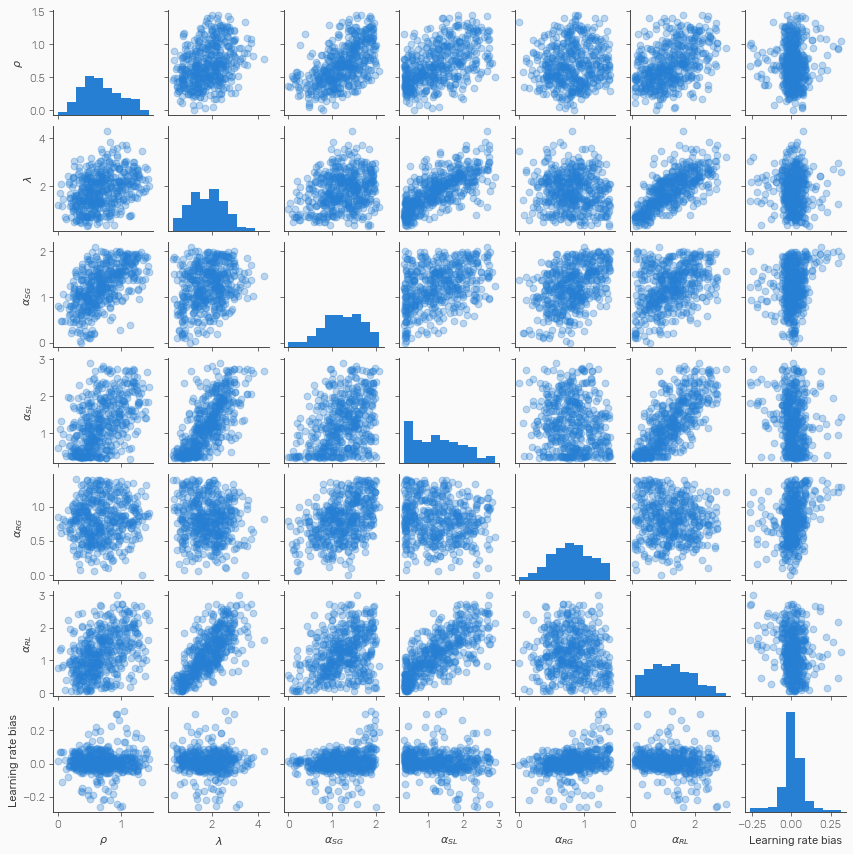

In [100]:
merged_df2 = merged_df.copy()
merged_df2 = merged_df2.rename(columns=dict(zip(MB_vars, MB_var_labels)))
g = sns.PairGrid(merged_df2[MB_var_labels], height=1.5)
g = g.map_diag(plt.hist, color=colours[0])
g = g.map_offdiag(plt.scatter, color=colours[0], alpha=0.3)
# plt.savefig('../figures/parameter_correlations.pdf')
# plt.savefig('../figures/parameter_correlations.png')

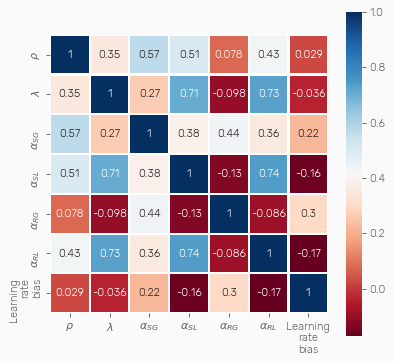

In [99]:
plt.figure(figsize=(5, 5), dpi=80)
sns.heatmap(merged_df2[MB_var_labels].rename(columns={'Learning rate bias': 'Learning\nrate\nbias'}).corr(), 
            cmap='RdBu', linewidth=1, square=True, annot=True)
# plt.savefig('../figures/parameter_correlation_matrix.pdf')
# plt.savefig('../figures/parameter_correlation_matrix.png')

## Parameter recovery

In [142]:
simulated = pd.read_csv('../data/gamble_fit_results/fitting_results__decision_model_id5__learning_model_id7_RECOVERY_SIM_VALUES.csv')
recovered = pd.read_csv('../data/gamble_fit_results/fitting_results__decision_model_id5__learning_model_id7_RECOVERY__anon.csv')
simulated['subjectID'] = recovered2['subjectID'].unique()
simulated = simulated.sort_values('subjectID')
recovered = recovered.sort_values('subjectID')

In [143]:
simulated.columns = [c + '_sim' if not 'sim' in c else c for c in simulated.columns]

In [144]:
simulated.head()

,Unnamed: 0_sim,rho_sim,lambda_sim,gamma_sim,alpha_rg_sim,alpha_rl_sim,alpha_sg_sim,alpha_sl_sim,theta_sim,estimated_amb_gain_LR_sim,estimated_amb_loss_LR_sim,subjectID_sim
155,155,2.636874,2.282160,1.989617,3.436546,1.380720,3.324862,1.780606,2.529268,0.195801,0.259198,sub0008
16,16,1.603393,2.389601,2.033805,2.189042,1.513766,2.085336,1.102060,1.735584,0.279686,0.219962,sub0009
157,157,2.147628,2.684645,1.623630,1.994588,2.402122,1.743681,2.230025,1.611310,0.159814,0.186309,sub0010
354,354,1.679888,1.886726,1.734140,1.696603,2.211097,2.030216,1.683278,1.536827,0.210564,0.265486,sub0011
317,317,4.162180,1.706974,2.543460,2.278443,2.001859,1.525882,2.184069,2.273037,0.171062,0.159316,sub0019


In [145]:
recovered = recovered[~recovered['parameter'].isin(['estimated_amb_gain', 'estimated_amb_loss', 'estimated_amb_gain_var', 'estimated_amb_loss_var'])]
recovered = recovered.pivot(index='subjectID', columns='parameter', values=['mean', 'sd']).reset_index()

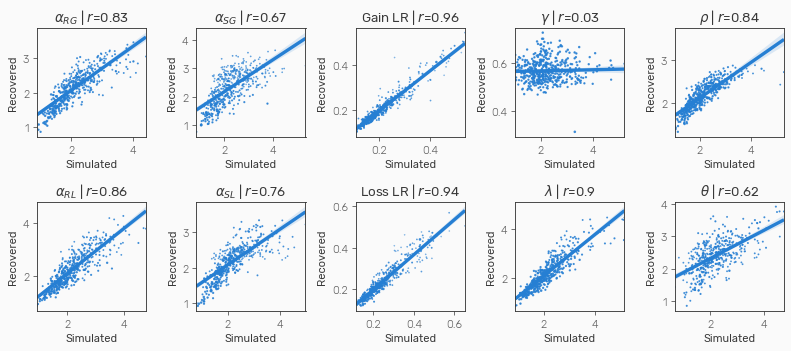

In [147]:
colours = ['#' + i for i in '267fd3-d3265a-ffbc42-44af69'.split('-')] + ['#197278']

params = [c for c in recovered['mean'].columns if not 'parameter' in c and not 'subject' in c]
f, ax = plt.subplots(2, int(np.ceil(len(params) / 2)), figsize=(10, 4.5))

varnames = [r'$\alpha_{RG}$', r'$\alpha_{RL}$', r'$\alpha_{SG}$', r'$\alpha_{SL}$', 'Gain LR', 'Loss LR', r'$\gamma$', r'$\lambda$', r'$\rho$', r'$\theta$']

for n, i in enumerate(params):
    sns.regplot(simulated[i + '_sim'], recovered['mean'][i], ax=ax[n % 2, int(n / 2)], 
                line_kws={'lw': 3}, scatter_kws={'s': ((1 / recovered['sd'][i]) / np.max(1 / recovered['sd'][i])) * 2}, color=colours[0])
    ax[n % 2, int(n / 2)].set_xlabel('Simulated')
    ax[n % 2, int(n / 2)].set_ylabel('Recovered')
    ax[n % 2, int(n / 2)].set_title(varnames[n] + r' | $r$={0}'.format(np.round(pearsonr(simulated[i + '_sim'], recovered['mean'][i])[0], 2)))
    
plt.tight_layout()
# plt.savefig('../figures/parameter_recovery.svg')